<a href="https://colab.research.google.com/github/GeorgeSakketos/Data_Mining_Exercice_02/blob/main/Data_Mining_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Τεχνικές Εξόρυξης Δεδομένων**
## **Εργασία 2**
**Σακκέτος Γεώργιος - 1115202000177**

**Γαλανός Αλέξανδρος - 1115201900032**

# Connect Google Drive

In [68]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **Μέρος 1**

In [69]:
# Dependences
!pip install transformers langdetect langid

In [70]:
import pandas as pd
import numpy as np
from transformers import pipeline
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from gensim.models import Word2Vec
from langdetect import detect
import string
import re
import nltk
import sys

nltk.download('stopwords')
nltk.download('punkt')

print('Python version ' + sys.version)

filePath = '/content/gdrive/My Drive/Data_Mining_CSV/2023/'

Python version 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


June

In [71]:
#Read June CSV
filePath_june = filePath + 'june/'
june_listings_2023 = pd.read_csv(filePath_june + 'reviews.csv', thousands = ',')

# Keep the Columns we want
june_listings_2023 = june_listings_2023[['id', 'comments']]

March

In [72]:
#Read March CSV
filePath_march = filePath + 'march/'
march_listings_2023 = pd.read_csv(filePath_march + 'reviews.csv', thousands = ',')

# Keep the Columns we want
march_listings_2023 = march_listings_2023[['id', 'comments']]

September

In [73]:
#Read September CSV
filePath_september = filePath + 'september/'
september_listings_2023 = pd.read_csv(filePath_september + 'reviews.csv', thousands = ',')

# Keep the Columns we want
september_listings_2023 = september_listings_2023[['id', 'comments']]

Combine Dataframes

In [74]:
dfs = [june_listings_2023, march_listings_2023, september_listings_2023]

# Combine June, March and September into one Dataframe
final_reviews_2023 = pd.concat(dfs, ignore_index = True)

# Reset Index
final_reviews_2023 = final_reviews_2023.reset_index(drop=True)

Clean the Data

In [75]:
# Rename 'comments' column to 'review'
final_reviews_2023 = final_reviews_2023.rename(columns={"comments": "review"})

# Remove NaN lines
final_reviews_2023 = final_reviews_2023.dropna()

# Remove Duplicate IDs
final_reviews_2023 = final_reviews_2023.drop_duplicates(subset='id', keep='first')

# Convert 'review' to lowercase
final_reviews_2023['review'] = final_reviews_2023['review'].str.lower()

# Remove emojis
final_reviews_2023['review'] = final_reviews_2023['review'].str.replace(r'[\U0001F600-\U0001F64F]', '', regex=True)  # emoticons
final_reviews_2023['review'] = final_reviews_2023['review'].str.replace(r'[\U0001F300-\U0001F5FF]', '', regex=True)  # symbols & pictographs
final_reviews_2023['review'] = final_reviews_2023['review'].str.replace(r'[\U0001F680-\U0001F6FF]', '', regex=True)  # transport & map symbols
final_reviews_2023['review'] = final_reviews_2023['review'].str.replace(r'[\U0001F1E0-\U0001F1FF]', '', regex=True)  # flags (iOS)

# Remove URLs
final_reviews_2023['review'] = final_reviews_2023['review'].str.replace(r'http\S+|www.\S+', '', regex=True)

# Remove hashtags
final_reviews_2023['review'] = final_reviews_2023['review'].str.replace(r'#\w+', '', regex=True)

# Remove special characters (keeping only alphanumeric and spaces)
final_reviews_2023['review'] = final_reviews_2023['review'].str.replace(r'[^A-Za-z0-9 ]+', '', regex=True)

# Remove stopwords
stop_words = set(stopwords.words('english'))
final_reviews_2023['review'] = final_reviews_2023['review'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

final_reviews_2023 = final_reviews_2023.reset_index(drop = True)
pd.set_option('display.max_colwidth', None)
print(final_reviews_2023['review'])

0                                                                                                                                                                                                                                                                              apartment wonderful fully equiped beautiful decor comfortable verry clean would stay possibly another host properties close metro markets grocery store conveniences
1         emmanouil excellent host provided us everything need make feel right home gave us tips directions destinations even prior trip kept close contact gave us specific easy instructions get place place spacious comfortable everything neat organized always great place come back adventurous day athens transportation easily accessible place located quiet neighborhood stay amazing experience wouldnt hesitate stay recommend friends
2                                                                                                                               

Export Dataframe to CSV

In [ ]:
final_reviews_2023.to_csv('/content/gdrive/My Drive/Data_Mining_CSV/2023/comments_2023.csv', index = False)

Open comments_2023 CSV

In [ ]:
final_reviews_2023 = pd.read_csv(filePath + 'comments_2023.csv')

Keep Only English Reviews

In [76]:
import langid

def is_english(text):
    lang, _ = langid.classify(text)
    return lang == 'en'

# Copy the first 50000 reviews and drop rows with NaN values in the 'review' column
english_reviews_2023 = final_reviews_2023.head(10000).copy().dropna(subset=['review'])

# Apply the is_english function
english_reviews_2023.loc[:, 'is_english'] = english_reviews_2023['review'].apply(is_english)

# Filter reviews that are in English
english_reviews_2023 = english_reviews_2023[english_reviews_2023['is_english']]

print(len(english_reviews_2023))

8409


Use HuggingFace Model

In [77]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

# Keep first 1000 reviews
english_reviews_2023 = english_reviews_2023.head(1000)

# Create a copy
english_reviews_2023 = english_reviews_2023.copy()

# Model
model = AutoModelForSequenceClassification.from_pretrained("j-hartmann/sentiment-roberta-large-english-3-classes")
tokenizer = AutoTokenizer.from_pretrained("j-hartmann/sentiment-roberta-large-english-3-classes")
nlp = pipeline("text-classification",model = model,tokenizer = tokenizer)

# Batch Size (ex. 100)
batch_size = 100

# Function to split reviews into chunks and process them
def batch_process_reviews(reviews, batch_size):
  sentiments = []
  for i in range(0, len(reviews), batch_size):
    print(i)
    batch = reviews[i:i + batch_size]
    results = nlp(batch.tolist())
    sentiments.extend([result['label'] for result in results])
  return sentiments

# Process reviews and get sentiments
reviews = english_reviews_2023['review']
english_reviews_2023['sentiment'] = batch_process_reviews(reviews, batch_size)

print(english_reviews_2023.tail(30))

Some weights of the model checkpoint at j-hartmann/sentiment-roberta-large-english-3-classes were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
100
200
300
400
500
600
700
800
900
             id  \
1110  325940693   
1111  326848221   
1112  328803893   
1113  330217569   
1114  331654579   
1115  333282759   
1116  335111919   
1117  337442666   
1118  337943430   
1121  349058830   
1122  350360320   
1123  351009537   
1124   12142323   
1125   12472095   
1126   12602225   
1127   12679419   
1128   12754429   
1129   12911514   
1130   13027876   
1131   13065404   
1132   13252750   
1133   13303995   
1134   13359046   
1135  356814855   
1136  357432491   
1137  366679751   
1138  401591497   
1139  405512113   
1141  413801028   
1142  418924706   

                                                                                                                                                                                                                                                                                                                                                                                    

Chart Results

sentiment
positive    810
neutral     172
negative     18
Name: count, dtype: int64


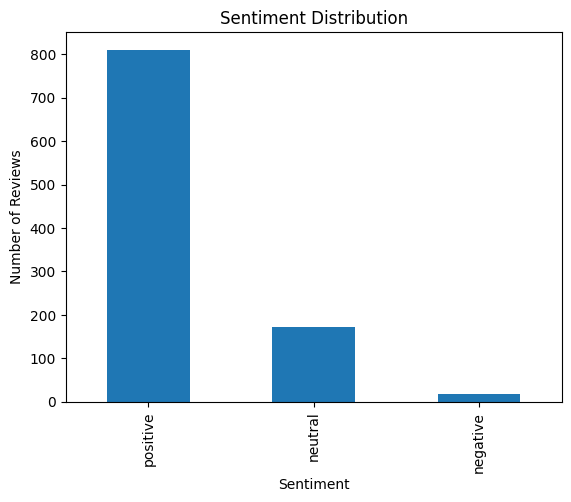

In [78]:
import matplotlib.pyplot as plt

reviews_2023 = english_reviews_2023.copy()

# Drop 'is_english' column
reviews_2023 = reviews_2023.drop(['is_english'], axis = 1)
reviews_2023 = reviews_2023.reset_index(drop = True)

# Plot the Histogram
sentiment_count = reviews_2023['sentiment'].value_counts()
print(sentiment_count)
sentiment_count.plot(kind='bar')

# Title and Label
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')

# Show Plot
plt.show()

Συγκρίνοντας τα αποτελέσματα του 2019 με το 2023, παρατηρούμε ότι στο 2019 μεγάλη μείωση των θετικών τιμών που είναι 864 με τις θετικές τιμές του 2023 πυ είναι 810. Επίσης υπάρχει αύξηση των ουδέτερων τιμών του 2019 από 103 σε 172 το 2023. Παράλληλα, οι αρνητικές τιμές του 2019 μειώθηκαν από 33 σε 18 το 2023. Συνολικά, το 2023 δείχνει μια μείωση των θετικών και αρνητικών αντιδράσεων σε σχέση με το 2019, ενώ οι ουδέτερες αντιδράσεις έχουν αυξηθεί σημαντικά.

Export Resulting Dataframe

In [ ]:
english_reviews_2023 = english_reviews_2023.reset_index(drop = True)
english_reviews_2023.to_csv('/content/gdrive/My Drive/Data_Mining_CSV/2023/reviews_2023.csv', index = False)

# **Μέρος 2**

Open File

In [ ]:
english_reviews_2023 = pd.read_csv(filePath + 'reviews_2023.csv')

Match Sentiments with numbers (positive = 1, neutral = 0, negative = 2)

In [79]:
sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': 2}
english_reviews_2023['sentiment'] = english_reviews_2023['sentiment'].map(sentiment_mapping)

print(english_reviews_2023.head())

         id  \
0    271535   
1   1994237   
2  12184199   
3  13197921   
4  13393565   

                                                                                                                                                                                                                                                                                                                                                                                                                                      review  \
0                                                                                                                                                                                                                                                                       apartment wonderful fully equiped beautiful decor comfortable verry clean would stay possibly another host properties close metro markets grocery store conveniences   
1  emmanouil excellent host provided us every

Prepare Data Points

In [80]:
from sklearn.model_selection import train_test_split

train_reviews, test_reviews = train_test_split(english_reviews_2023, test_size = 0.2, random_state = 42)

# Save to .tsv format
train_reviews.to_csv(filePath + 'train.tsv', sep='\t', index = False)
test_reviews.to_csv(filePath + 'test.tsv', sep='\t', index = False)

Characteristics Preparation with TF-IDF

In [81]:
from sklearn.feature_extraction.text import TfidfVectorizer

train_reviews['review'] = train_reviews['review'].fillna('')
test_reviews['review'] = test_reviews['review'].fillna('')

# Vectorizer Creation
tfidf_Vectorizer = TfidfVectorizer(max_df=0.1, min_df=1, max_features=200)

# Convert to TF-IDF train data reviews
X_train_tfidf = tfidf_Vectorizer.fit_transform(train_reviews['review'])

# Convert to TF-IDF test data reviews
X_test_tfidf = tfidf_Vectorizer.fit_transform(test_reviews['review'])

# Shape Check
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(800, 200)
(200, 200)


Characteristics Preparation with Word Embeddings using Word2Vec model

In [82]:
# Seperate reviews to words
train_sentence = [review.split() for review in train_reviews['review']]
test_sentence = [review.split() for review in test_reviews['review']]

# Train Word2Vec model
word2vecModel = Word2Vec(sentences=train_sentence, vector_size=200, window=5, min_count=1, workers=4, seed=42)

# Function for calculating the mean of words to get the embedding for the review
def embedding_review(review, model):
  words = review.split()
  word_vectors = [model.wv[word] for word in words if word in model.wv]
  if len(word_vectors) == 0:
    return np.zeros(model.vector_size)
  else:
    return np.mean(word_vectors, axis=0)

# Train dataset using Word Embeddings
X_train_embeddings = np.vstack([embedding_review(review, word2vecModel) for review in train_reviews['review']])

# Test dataset using Word Embeddings
X_test_embeddings = np.vstack([embedding_review(review, word2vecModel) for review in test_reviews['review']])

# Shape Check
print(X_train_embeddings.shape)
print(X_test_embeddings.shape)

(800, 200)
(200, 200)


Save to pickle file

In [83]:
import pickle

# Save TF-IDF Files
with open(filePath + 'X_train_tfidf.pkl', 'wb') as file:
  pickle.dump(X_train_tfidf, file)

with open(filePath + 'X_test_tfidf.pkl', 'wb') as file:
  pickle.dump(X_test_tfidf, file)

# Save Word2Vec Files
with open(filePath + 'X_train_embeddings.pkl', 'wb') as file:
  pickle.dump(X_train_embeddings, file)

with open(filePath + 'X_test_embeddings.pkl', 'wb') as file:
  pickle.dump(X_test_embeddings, file)

# Save TF-IDF Vectorizer
with open(filePath + 'tfidf_vectorizer.pkl', 'wb') as file:
  pickle.dump(tfidf_Vectorizer, file)

# Save Sentiments
with open(filePath + 'Y_train_reviews.pkl', 'wb') as file:
  pickle.dump(train_reviews['sentiment'].values, file)

with open(filePath + 'Y_test_reviews.pkl', 'wb') as file:
  pickle.dump(test_reviews['sentiment'].values, file)

Load from pickle file

In [84]:
import pickle

# Load TF-IDF Files
with open(filePath + 'X_train_tfidf.pkl', 'rb') as file:
  X_train_tfidf = pickle.load(file)

with open(filePath + 'X_test_tfidf.pkl', 'rb') as file:
  X_test_tfidf = pickle.load(file)

# Load Word2Vec Files
with open(filePath + 'X_train_embeddings.pkl', 'rb') as file:
  X_train_embeddings = pickle.load(file)

with open(filePath + 'X_test_embeddings.pkl', 'rb') as file:
  X_test_embeddings = pickle.load(file)

# Load TF-IDF Vectorizer
with open(filePath + 'tfidf_vectorizer.pkl', 'rb') as file:
  tfidf_Vectorizer = pickle.load(file)

# Load Sentiments
with open(filePath + 'Y_train_reviews.pkl', 'rb') as file:
  Y_train_reviews = pickle.load(file)

with open(filePath + 'Y_test_reviews.pkl', 'rb') as file:
  Y_test_reviews = pickle.load(file)

For TF-IDF Characteristics we use SVM sorting

In [85]:
from sklearn import svm
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, make_scorer
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold

# Custom scorer functions to handle zero_division
def precision_macro(y_true, y_pred):
    return precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)[0]

def recall_macro(y_true, y_pred):
    return precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)[1]

def f1_macro(y_true, y_pred):
    return precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)[2]

# Define custom scorers
scoring = {
    'precision_macro': make_scorer(precision_macro),
    'recall_macro': make_scorer(recall_macro),
    'f1_macro': make_scorer(f1_macro),
    'accuracy': 'accuracy'
}

# Load Classifer
classifier_svm = svm.SVC()

# Train SVM
classifier_svm.fit(X_train_tfidf, Y_train_reviews)

# Predict at test data
Y_pred_svm = classifier_svm.predict(X_test_tfidf)

# Evaluate Classifier using Cross-Validation
scores = cross_validate(classifier_svm, X_train_tfidf, Y_train_reviews, cv=10, scoring=scoring)

# Print Cross-Validation Results
print(f"Cross-Validation Results:")
print(f"Precision: {np.mean(scores['test_precision_macro']):.4f}")
print(f"Recall: {np.mean(scores['test_recall_macro']):.4f}")
print(f"F1 Score: {np.mean(scores['test_f1_macro']):.4f}")
print(f"Accuracy: {np.mean(scores['test_accuracy']):.4f}")
print("\n")

# Evaluate Test Data
test_accuracy = accuracy_score(Y_test_reviews, Y_pred_svm)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(Y_test_reviews, Y_pred_svm, average='macro', zero_division=0)

# Print Results
print("Test Data Results:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")


Cross-Validation Results:
Precision: 0.6533
Recall: 0.5936
F1 Score: 0.6152
Accuracy: 0.9037


Test Data Results:
Test Accuracy: 0.8800
Test Precision: 0.5492
Test Recall: 0.5086
Test F1 Score: 0.5241


For TF-IDF Characteristics we use Random Forests sorting

In [86]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, make_scorer
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold

# Custom scorer functions to handle zero_division
def precision_macro(y_true, y_pred):
    return precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)[0]

def recall_macro(y_true, y_pred):
    return precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)[1]

def f1_macro(y_true, y_pred):
    return precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)[2]

# Define custom scorers
scoring = {
    'precision_macro': make_scorer(precision_macro),
    'recall_macro': make_scorer(recall_macro),
    'f1_macro': make_scorer(f1_macro),
    'accuracy': 'accuracy'
}

# Load Classifier
classifier_rf = RandomForestClassifier()

# Train Random Forest
classifier_rf.fit(X_train_tfidf, Y_train_reviews)

# Predict at test data
Y_pred_rf = classifier_rf.predict(X_test_tfidf)

# Evaluate Classifier using Cross-Validation
scores = cross_validate(classifier_rf, X_train_tfidf, Y_train_reviews, cv=10, scoring=scoring)

# Print Cross-Validation Results
print(f"Cross-Validation Results:")
print(f"Precision: {np.mean(scores['test_precision_macro']):.4f}")
print(f"Recall: {np.mean(scores['test_recall_macro']):.4f}")
print(f"F1 Score: {np.mean(scores['test_f1_macro']):.4f}")
print(f"Accuracy: {np.mean(scores['test_accuracy']):.4f}")
print("\n")

# Evaluate Test Data
test_accuracy = accuracy_score(Y_test_reviews, Y_pred_rf)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(Y_test_reviews, Y_pred_rf, average='macro', zero_division=0)

# Print Results
print("Test Data Results:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")


Cross-Validation Results:
Precision: 0.6070
Recall: 0.5836
F1 Score: 0.5909
Accuracy: 0.8750


Test Data Results:
Test Accuracy: 0.8100
Test Precision: 0.4583
Test Recall: 0.4970
Test F1 Score: 0.4742


For TF-IDF Characteristics we use KNN sorting

In [87]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, make_scorer
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold

# Custom scorer functions to handle zero_division
def precision_macro(y_true, y_pred):
    return precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)[0]

def recall_macro(y_true, y_pred):
    return precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)[1]

def f1_macro(y_true, y_pred):
    return precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)[2]

# Define custom scorers
scoring = {
    'precision_macro': make_scorer(precision_macro),
    'recall_macro': make_scorer(recall_macro),
    'f1_macro': make_scorer(f1_macro),
    'accuracy': 'accuracy'
}

# Load Classifier
classifier_knn = KNeighborsClassifier()

# Train KNN
classifier_knn.fit(X_train_tfidf, Y_train_reviews)

# Predict at test data
Y_pred_knn = classifier_knn.predict(X_test_tfidf)

# Evaluate Classifier using Cross-Validation
scores = cross_validate(classifier_knn, X_train_tfidf, Y_train_reviews, cv=10, scoring=scoring)

# Print Cross-Validation Results
print(f"Cross-Validation Results:")
print(f"Precision: {np.mean(scores['test_precision_macro']):.4f}")
print(f"Recall: {np.mean(scores['test_recall_macro']):.4f}")
print(f"F1 Score: {np.mean(scores['test_f1_macro']):.4f}")
print(f"Accuracy: {np.mean(scores['test_accuracy']):.4f}")
print("\n")

# Evaluate Test Data
test_accuracy = accuracy_score(Y_test_reviews, Y_pred_knn)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(Y_test_reviews, Y_pred_knn, average='macro', zero_division=0)

# Print Results
print("Test Data Results:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")


Cross-Validation Results:
Precision: 0.3843
Recall: 0.4044
F1 Score: 0.2664
Accuracy: 0.4012


Test Data Results:
Test Accuracy: 0.2600
Test Precision: 0.3395
Test Recall: 0.3572
Test F1 Score: 0.1743


**Συμπέρασμα**


Ως προς το accuracy, δηλαδή το συνολικό ποσοστό σωστών προβλέψεων, παρατηρούμε ότι το μοντέλο SVM παρουσιάζει την υψηλότερη απόδοση με 88% ακρίβεια στα Test Data. Τα αποτελέσματα των Random Forests είναι επίσης αξιόλογα με ακρίβεια 81%, ενώ το μοντέλο ΚΝΝ αποδίδει πολύ χαμηλά με μόλις 26% ακρίβεια. Όσον αφορά τη μετρική F1, η οποία αποτελεί το αρμονικό μέσο των μετρικών Precision και Recall, παρατηρούμε ότι το SVM υπερέχει και πάλι με F1 score 0.5241, δείχνοντας την καλύτερη συνολική απόδοση. Αντίθετα, το Random Forests έχει F1 score 0.4742, που υποδηλώνει μια μέτρια απόδοση, ενώ το ΚΝΝ εμφανίζει πολύ χαμηλή απόδοση με F1 score μόλις 0.1743. Συνολικά, τα αποτελέσματα δείχνουν ότι τα μοντέλα SVM και Random Forests με τη χρήση των κατάλληλων χαρακτηριστικών μπορούν να προσφέρουν καλύτερες προβλέψεις σε σύγκριση με το ΚΝΝ.

# **Μερος 3**

Open File

In [5]:
english_reviews_2023 = pd.read_csv(filePath + 'reviews_2023.csv')

Train model from reviews

In [62]:
# Word Sample (ex. 500 reviews)
review_sample = english_reviews_2023.head(500)
review_sample = english_reviews_2023.copy()

sentences = [review.split() for review in review_sample['review']]

# Find the 100 most commonly used words
words = [word for tokens in sentences for word in tokens]
counter = Counter(words)
most_commonly_used_words = [word for word, count in counter.most_common(100)]

# Initialize and Train Word2Vec Model
model = Word2Vec(sentences, vector_size=200, window=5, min_count=1, workers=4)

# Word Embeddings for Most Commonly Used Words
word_embeddings = {word: model.wv[word] for word in most_commonly_used_words if word in model.wv}

# Display Word Embeddings
for word, embedding in word_embeddings.items():
  print(f"{word}: {embedding[:5]}...")

apartment: [ 0.41075388 -0.25669166 -0.05741613 -0.00166777  0.31903934]...
great: [ 0.15796134 -0.03334573 -0.41195387  0.38275883  0.41793326]...
us: [-0.8484856   0.41919798 -0.11584564  0.4592939   0.84766287]...
stay: [ 0.21732667 -0.26091832  0.3982201   0.56001663  0.17633805]...
athens: [-0.15204936 -0.44921663  0.19097972  0.5709127   0.5071844 ]...
place: [ 0.39232674 -0.27253166  0.1698402   0.19109286  0.22162144]...
location: [ 0.74247205 -0.81031144  0.22592819 -0.52503496  0.41141853]...
host: [0.07054888 0.13442798 0.06107657 0.49072063 0.34848988]...
everything: [ 0.4874172   0.21561922  0.595288   -0.13517928  0.7893461 ]...
clean: [ 0.98410946 -0.23252347 -0.4559646  -0.3550191   0.45615512]...
nice: [ 0.23615375 -0.15008982 -0.48447317  0.07947539  0.24367087]...
would: [-0.15113822 -0.42732736  0.03331214  0.90297043  0.12589677]...
recommend: [-0.13782822 -0.78807324  0.21447955  0.64309466 -0.44329295]...
really: [ 0.15524988  0.00261006 -0.21739145  0.17732008  

Calculate Cosine Similarity

In [63]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

# Word Embeddings for All Most Common Used Words
word_embeddings_matrix = np.array([word_embeddings[word] for word in most_commonly_used_words])

# Normalize embeddings
normalized_embeddings_matrix = normalize(word_embeddings_matrix, axis=1, norm='l2')

# Calculate Cosine Similarity for all word pairs
cosine_similarities = cosine_similarity(word_embeddings_matrix)

# Similarities Dictionary
similarities_dict = {}

# Fill Similarities Dictionary with words as keys and a list of similarities as values
for x, x_word in enumerate(most_commonly_used_words):
    temp_lst = []
    for y, y_word in enumerate(most_commonly_used_words):
        if x != y:  # Exclude self-similarity
            similarity = cosine_similarities[x][y]
            temp_lst.append((y_word, similarity))
    similarities_dict[x_word] = temp_lst

# Sort Key Values (word) based on Similarity Scores
for key, value in similarities_dict.items():
    similarities_dict[key] = sorted(value, key=lambda x: x[1], reverse=True)

# Results
for x, y in similarities_dict.items():
    print(x, y)

apartment [('flat', 0.9589679), ('house', 0.8805188), ('clean', 0.87680316), ('spacious', 0.8684752), ('place', 0.8595328), ('location', 0.83698565), ('super', 0.8356085), ('really', 0.8218239), ('space', 0.81940496), ('comfortable', 0.8163752), ('well', 0.80953133), ('lovely', 0.79709643), ('beautiful', 0.77629447), ('family', 0.7601439), ('view', 0.74476266), ('balcony', 0.74085456), ('located', 0.74079674), ('everything', 0.73879594), ('perfect', 0.7335897), ('loved', 0.72106653), ('fantastic', 0.71743137), ('nice', 0.71432686), ('amazing', 0.6906067), ('host', 0.6856121), ('quiet', 0.68546283), ('close', 0.6725171), ('excellent', 0.6667797), ('city', 0.6636709), ('wonderful', 0.66089773), ('area', 0.660726), ('much', 0.6497061), ('neighborhood', 0.6482196), ('kitchen', 0.64268446), ('little', 0.6371335), ('need', 0.6324584), ('stay', 0.6270072), ('enjoyed', 0.62246394), ('needed', 0.6206222), ('great', 0.6166515), ('room', 0.60409147), ('acropolis', 0.60402215), ('experience', 0.60

Function to calculate the semantic neighborhood of two words and the 3 divider similarities

In [65]:
from scipy.stats import pearsonr
import math

def similarity_neighbourhood(x_word, y_word, N):
  neighbourhood_x_word = []
  neighbourhood_y_word = []
  S_w1_N1 = []
  S_w2_N2 = []

  # Loop through Dictionary
  for x,y in similarities_dict.items():
    if x_word == x:
      print(f"Similarity Neighbourhood for Word '{x_word}' of {N} items: {y[1:N+1]}")
      neighbourhood_x_word = y[1:N+1]
      for items in neighbourhood_x_word:
        S_w1_N1.append(items[1])
      print("\n")

    if y_word == x:
      print(f"Similarity Neighbourhood for Word '{y_word}' of {N} items: {y[1:N+1]}")
      neighbourhood_y_word = y[1:N+1]
      for items in neighbourhood_y_word:
        S_w2_N2.append(items[1])
      print("\n")

  print("Calculating Similarity (a):")
  print(f"For word '{x_word}': ")
  x_max = -100
  y_max = -100
  max_x_word = ''
  max_y_word = ''

  # Variables to keep all similarities between neighbourhoods
  cor_x = []
  cor_y = []
  for i, word_i in enumerate(most_commonly_used_words):
    if x_word == word_i:
      for j, word_j in enumerate(most_commonly_used_words):
        if any(word_j == tup[0] for tup in neighbourhood_y_word):
          print(f"Similarity ({word_i}, {word_j}) : {cosine_similarities[i][j]}")
          similarity = cosine_similarities[i][j]
          cor_x.append((word_j, similarity))
          if cosine_similarities[i][j] > x_max:
            x_max = cosine_similarities[i][j]
            max_x_word = word_j

  print("\n")
  print(f"For word '{y_word}': ")
  for i, word_i in enumerate(most_commonly_used_words):
    if y_word == word_i:
      for j, word_j in enumerate(most_commonly_used_words):
        if any(word_j == tup[0] for tup in neighbourhood_x_word):
          print(f"Similarity ({word_i}, {word_j}) : {cosine_similarities[i][j]}")
          similarity = cosine_similarities[i][j]
          cor_y.append((word_j, similarity))
          if cosine_similarities[i][j] > y_max:
            y_max = cosine_similarities[i][j]
            max_y_word = word_j

  print("\n")

  if (x_max > y_max):
    print(f"Similarity Max ({x_word}, {max_x_word}) : {x_max}")
  else:
    print(f"Similarity Max ({y_word}, {max_y_word}) : {y_max}")

  print("\n")
  print("Calculating similarity (b):")

  S_w1_N2 = []
  for x in cor_x:
    S_w1_N2.append(x[1])

  S_w2_N1 = []
  for y in cor_y:
    S_w2_N1.append(y[1])

  # Calculate Pearson Correlation Coefficient
  beta_ij = pearsonr(S_w1_N1, S_w2_N1)
  beta_ji = pearsonr(S_w1_N2, S_w2_N2)

  # Determine Rn(wi, wj)
  Rn_wi_wj = max(beta_ij, beta_ji)

  print(f"Similarity Rn(wi, wj): {Rn_wi_wj}")
  print("\n")

  print("Calculating similarity (c):")

  sum_w1 = 0
  sum_w2 = 0

  for i in S_w1_N2:
    sum_w2 += i ** 2

  for i in S_w2_N1:
    sum_w2 += i ** 2

  sum = math.sqrt(sum_w1 + sum_w2)
  print(f"Sum of squared neighbourhood similarities: {sum}")

In [66]:
# Test Function

words_to_analyze = ["home", "neighborhood", "station"]
neighbourhood_sizes = [3, 5, 10]

# Function to calculate the changes in similarity for the neighbourhoods
def analyze_neighborhood_changes(words, sizes):
    for N in sizes:
      print("--------------------------------")
      print(f"==== Neighbourhood Size Ν={N} ====")
      print("--------------------------------")
      for word in words:
        print("-------------------------------------------")
        print(f"Word Neighbourhood '{word}' for Ν={N}:")
        print("-------------------------------------------")
        similarity_neighbourhood(word, word, N)
        print("\n")

analyze_neighborhood_changes(words_to_analyze, neighbourhood_sizes)

--------------------------------
==== Neighbourhood Size Ν=3 ====
--------------------------------
-------------------------------------------
Word Neighbourhood 'home' for Ν=3:
-------------------------------------------
Similarity Neighbourhood for Word 'home' of 3 items: [('feel', 0.95184964), ('like', 0.9320164), ('made', 0.77459854)]


Similarity Neighbourhood for Word 'home' of 3 items: [('feel', 0.95184964), ('like', 0.9320164), ('made', 0.77459854)]


Calculating Similarity (a):
For word 'home': 
Similarity (home, like) : 0.9320163726806641
Similarity (home, made) : 0.7745985388755798
Similarity (home, feel) : 0.951849639415741


For word 'home': 
Similarity (home, like) : 0.9320163726806641
Similarity (home, made) : 0.7745985388755798
Similarity (home, feel) : 0.951849639415741


Similarity Max (home, feel) : 0.951849639415741


Calculating similarity (b):
Similarity Rn(wi, wj): PearsonRResult(statistic=-0.4999999999999999, pvalue=0.6666666666666667)


Calculating similarity (

**Συμπέρασμα**

Με την αύξηση της Παραμέτρου Ν παρατηρούμε ότι αυξάνεται το similarity (c) του αθροίσματος των τετραγώνων των similarities των λέξεων στις γειτονιές. Για Ν=3, οι τιμές για τις λέξεις 'home', 'neighborhood' και 'station' είναι 2.179, 2.163 και 2.314 αντίστοιχα. Για Ν=5, οι αντίστοιχες τιμές είναι 2.638, 2.769 και 2.878, ενώ για Ν=10, οι τιμές αυξάνονται περαιτέρω σε 3.311, 3.821 και 3.863. Από την άλλη, το similarity (b) παρουσιάζει μεικτές τάσεις. Για τη λέξη 'home', η τιμή του similarity (b) είναι -0.500 για Ν=3, 0.171 για Ν=5, και -0.302 για Ν=10. Για τη λέξη 'neighborhood', οι τιμές είναι -0.659 για Ν=3, -0.757 για Ν=5, και -0.121 για Ν=10. Για τη λέξη 'station', οι τιμές είναι 0.752 για Ν=3, -0.513 για Ν=5, και 0.097 για Ν=10. Όσον αφορά το similarity (a), οι μέγιστες τιμές για τη λέξη 'home' είναι 0.952, για τη λέξη 'neighborhood' είναι 0.890, και για τη λέξη 'station' είναι 0.956, ανεξαρτήτως του μεγέθους της γειτονιάς. Αυτές οι παρατηρήσεις δείχνουν ότι η αύξηση του μεγέθους της γειτονιάς επηρεάζει το συνολικό similarity, με τις τιμές να αυξάνονται σταθερά για το similarity (c), ενώ το similarity (b) παρουσιάζει μικρές διακυμάνσεις ανάλογα με τη λέξη και το μέγεθος της γειτονιάς.